# Import Modules

In [1]:
# Importing all the basic modules
import os
import pickle
import numpy as np

from PIL import Image
from IPython.display import display

from tqdm.notebook import tqdm

from tensorflow.keras.applications.inception_resnet_v2  import InceptionResNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, GRU

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting the directories to use the data
BASE_DIR = '/kaggle/input'
WORKING_DIR = '/kaggle/working'

print(os.listdir(BASE_DIR))

['dlimagedata', 'imagetext']


# Data Acquisition

### Reading the pickle file contains the image id and the text associated with the image.

In [3]:
pickle_fp = os.path.join(BASE_DIR, 'imagetext/set_0.pkl')
with open(pickle_fp, 'rb') as f:
    captions_doc = pickle.load(f)
    
img_caption_dict = {}
for l in captions_doc:
    l_split = l.split('#')
    # Getting the Image ID
    img_id = ''.join(l_split[0].split())
    
    # Storing the caption
    if img_id not in img_caption_dict:
        img_caption_dict[img_id] = []
    
    if img_id in img_caption_dict:
        c_list = img_caption_dict[img_id]
        c_text = l_split[1].split('\t')[1]
        c_list.append(c_text)
        img_caption_dict[img_id] = c_list

sample_id = '318667317_108c402140.jpg'
print(f"Captions available for Image name: {sample_id}:")
print("--"*50)
print(img_caption_dict[sample_id])

Captions available for Image name: 318667317_108c402140.jpg:
----------------------------------------------------------------------------------------------------
['A man in a black hoodie be hold a paper sign .', 'A homeless man carry a sign that say " hungry " .', 'A bearded man hold a sign .', 'A man in a black hoodie hold a small sign .']


In [4]:
print(f"Unique Images (Caption available) {len(img_caption_dict)}")

Unique Images (Caption available) 8037


### Reading the Image dataset Folder containing all the images

In [5]:
image_dataset_fp = os.path.join(BASE_DIR, 'dlimagedata/Flicker8k_Dataset')

# Plotting at least two samples and their captions

In [6]:
image_list = os.listdir(image_dataset_fp)

Displaying 3226254560_2f8ac147ea.jpg



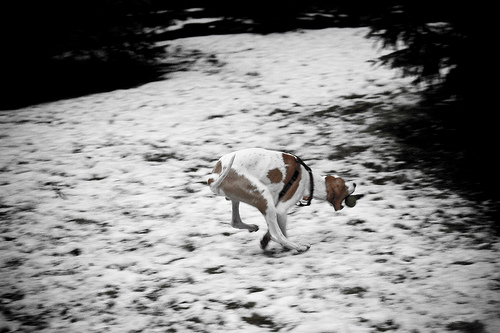

Captions available:
----------------------------------------------------------------------------------------------------
['A dog in a snowy area .', 'A white and brown spot dog run along the snow to catch a ball .', 'A spotted dog catch a ball on a snowy field .', 'A white dog be run fast on a trail cover by snow .']


Displaying 214543992_ce6c0d9f9b.jpg



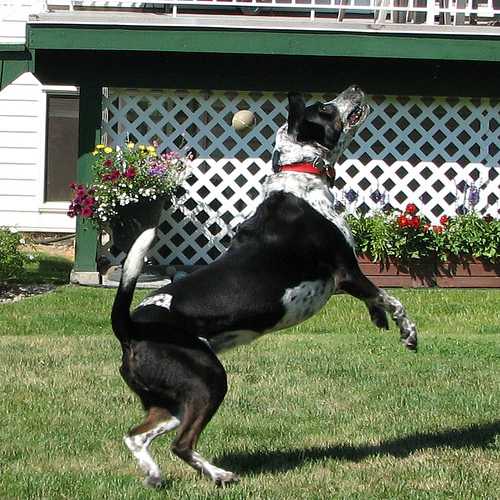

Captions available:
----------------------------------------------------------------------------------------------------
['dog jump look up and small white ball in air pass by', 'A black and white dog jump up as a ball be throw over his head .', 'A black and white dog be attempt to catch a ball in a garden .']


Displaying 2366643786_9c9a830db8.jpg



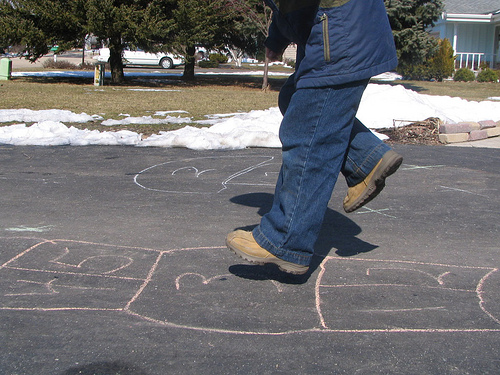

Captions available:
----------------------------------------------------------------------------------------------------
['Someone be play hopscotch on a chalk out grid on the ground .', 'Closeup of a pair of feet in mid jump while play hopscotch .', 'The leg of a child play hopscotch .', 'A child in denim play hopscotch .']


Displaying 3368819708_0bfa0808f8.jpg



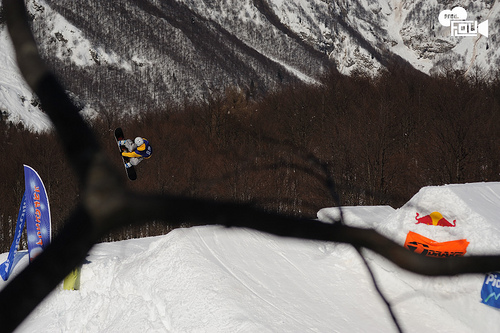

Captions available:
----------------------------------------------------------------------------------------------------
['A snowboarder be do a trick .', 'A viewer from a helicopter watch a snowboarder below', 'A snowboarder dress in yellow make a jump .', 'A snowboarder jump .', 'a snowboarder get air off a jump .']


Displaying 2190227737_6e0bde2623.jpg



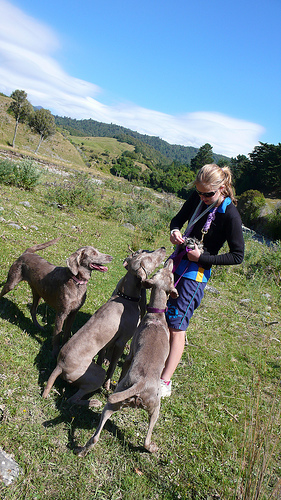

Captions available:
----------------------------------------------------------------------------------------------------
['A woman stand in a field surround by three attentive gray dog .', 'Three brown dog be jump up at a woman wear blue .', 'A girl hold something while three dog beg .']




In [7]:
for img_ in image_list[:5]:
    print(f"Displaying {img_}\n")
    img_fp = os.path.join(image_dataset_fp, img_)
    im = Image.open(img_fp)
    display(im)
    print(f"Captions available:")
    print("--"*50)
    print(img_caption_dict[img_])
    print()
    print()

# Model Building

### Use Pretrained Inception model trained on ImageNet dataset (available publicly on google) for image feature extraction.

In [8]:
# Load InceptionResNetV2 model
model = InceptionResNetV2()
# Restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# Summarize
print(model.summary())

2022-09-11 16:26:38.417402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 16:26:38.542299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 16:26:38.543265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 16:26:38.545288: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

225222656/225209952 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
___________________________

## Extracting Features from Images

In [9]:
## Extracting features from image using "InceptionResNetV2"
features = {}

for img_name in image_list:
    # Load the image from file
    img_path = os.path.join(image_dataset_fp, img_name)
    image = load_img(img_path, target_size=(299, 299))
    # Convert image pixels to numpy array
    image = img_to_array(image)
    # Reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess image for InceptionResNetV2
    image = preprocess_input(image)
    # Extract Features InceptionResNetV2
    feature = model.predict(image, verbose=0)
    features[img_name] = feature

2022-09-11 16:26:47.263212: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-11 16:26:51.230963: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [10]:
print(f"Unique Images {len(features)}")

Unique Images 8091


In [11]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [12]:
common_images = set(list(features)) & set(list(img_caption_dict))
print(f"Common Images across Image & Caption Dataset {len(common_images)}")

## Filtering out Common Images
img_caption_dict_c = {}
for img_ in common_images:
    img_caption_dict_c[img_] = img_caption_dict[img_]
    
    
## Filtering out Common Images
features_c = {}
for img_ in common_images:
    features_c[img_] = features[img_]

print("After Filtering")
print(f"{len(features_c)}")
print(f"{len(img_caption_dict_c)}")

Common Images across Image & Caption Dataset 8036
After Filtering
8036
8036


## Preprocess Captions Data

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [14]:
mapping = img_caption_dict_c.copy()

In [15]:
# Before Preprocessing
print("Before Preprocessing")
print (mapping['2190227737_6e0bde2623.jpg'])
# Preprocessing the Captions
clean(mapping)
# After Preprocessing
print("After Preprocessing")
print(mapping['2190227737_6e0bde2623.jpg'])

Before Preprocessing
['A woman stand in a field surround by three attentive gray dog .', 'Three brown dog be jump up at a woman wear blue .', 'A girl hold something while three dog beg .']
After Preprocessing
['startseq woman stand in field surround by three attentive gray dog endseq', 'startseq three brown dog be jump up at woman wear blue endseq', 'startseq girl hold something while three dog beg endseq']


## Store the preprocessed captions into a list

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        
print(f"Number of Unique captions stored : {len(all_captions)}")        

Number of Unique captions stored : 24996


In [17]:
all_captions[:10]

['startseq three small dog two of which be sniff nose endseq',
 'startseq two dog meet and check out third dog at beach endseq',
 'startseq three dog be stand in the sand endseq',
 'startseq two person wear ski stand look at mountain endseq',
 'startseq two man stand on ski and look to snowy mountain to the right endseq',
 'startseq some person be gather by mound of snow outside house endseq',
 'startseq people stand outside house endseq',
 'startseq person have just throw snowball and hit someone in the back endseq',
 'startseq man be train dog to zigzag through pole endseq',
 'startseq man run with his dog as person watch from nearby tent endseq']

## Tokenizing the Text Data 

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

31

## Train Test Split

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)

train = image_ids[:split]
test = image_ids[split:]

print(f"Training Images: {len(train)}")
print(f"Testing Images: {len(test)}")

Training Images: 7232
Testing Images: 804


## Defining a batch and including the padding sequence

Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.

In [20]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Define Model Architecture

- A 5 layered GRU layer model and other relevant layers for image caption generation.
- L2 regularization to all the GRU layers
- One layer of dropout

In [21]:
## Encoder model

# Image Feature Layers
inputs1 = Input(shape=(1536,))
f_layer1 = Dropout(0.2)(inputs1)
f_layer2 = Dense(256, activation='relu')(f_layer1)

# Sequence Feature Layers
inputs2 = Input(shape=(max_length,))
GRU_layer1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
## Adding Dropout after the embedding Layer 
## To Regularize the data, avoiding over fitting & dropping out a fraction of the data from the layers
GRU_layer2 = Dropout(0.2)(GRU_layer1)
GRU_layer3 = GRU(units=256, return_sequences=True, kernel_regularizer='l2', activation='relu')(GRU_layer2)
GRU_layer4 = GRU(units=256, return_sequences=True, kernel_regularizer='l2', activation='relu')(GRU_layer3)
GRU_layer5 = GRU(units=256, return_sequences=True, kernel_regularizer='l2', activation='relu')(GRU_layer4)
GRU_layer6 = GRU(units=256, return_sequences=True, kernel_regularizer='l2', activation='relu')(GRU_layer5)
GRU_layer7 = GRU(256, kernel_regularizer='l2')(GRU_layer6)

## Decoder Model
decoder1 = add([f_layer2, GRU_layer7])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

GRUmodel = Model(inputs=[inputs1, inputs2], outputs=outputs)
GRUmodel.compile(loss='categorical_crossentropy', optimizer='adam')

# Print The Model summary
GRUmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 512)      2734080     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 31, 512)      0           embedding[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, 31, 256)      591360      dropout_1[0][0]                  
____________________________________________________________________________________________

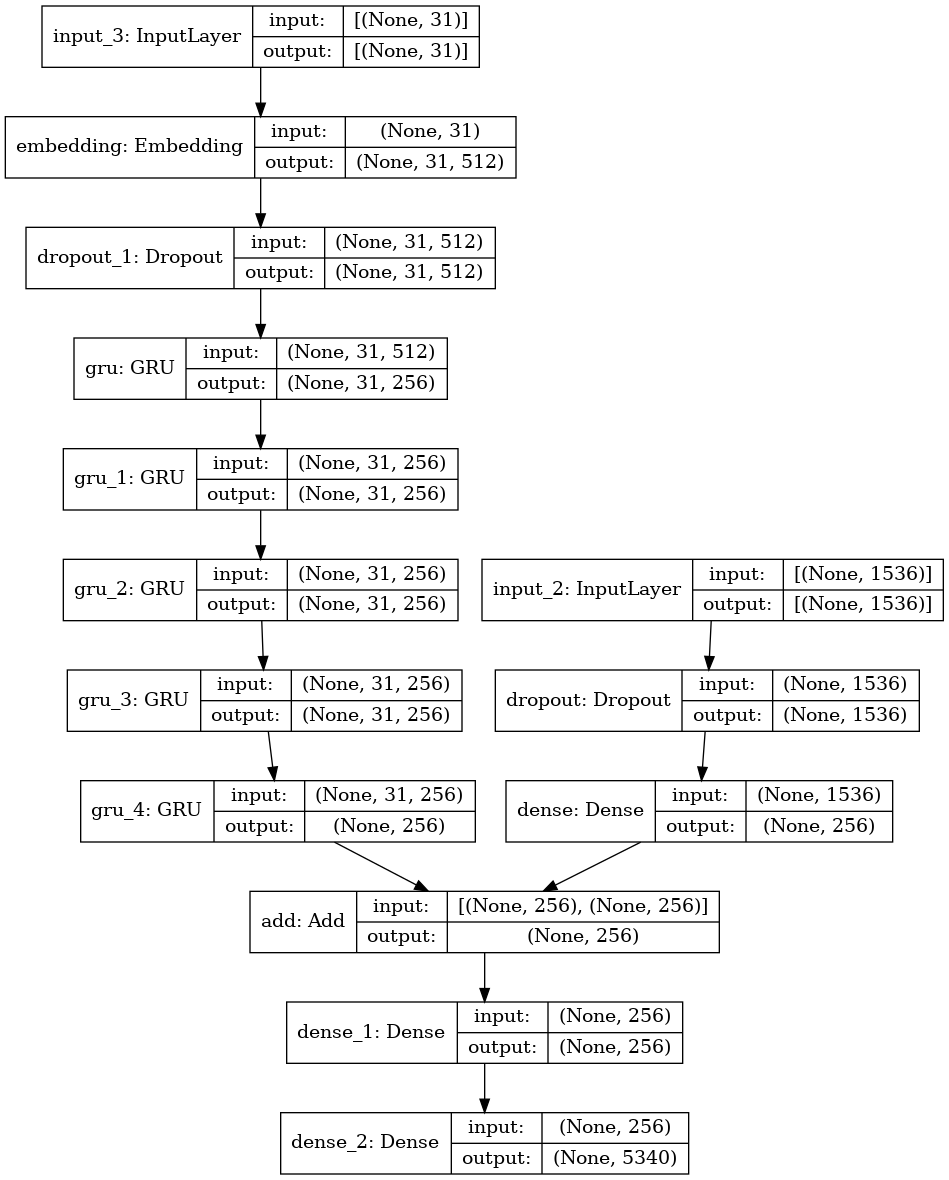

In [22]:
# plot the model
plot_model(GRUmodel, show_shapes=True)

## Training the Model

In [23]:
# train the model
epochs = 25
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, 
                               mapping, 
                               features_c, 
                               tokenizer,
                               max_length,
                               vocab_size,
                               batch_size)
    # fit for one epoch
    GRUmodel.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 80s 708ms/step - loss: 3.7002


# Model Evaluation

## Generate Captions for the sample test Images

Displaying 2883950737_3b67d24af4.jpg



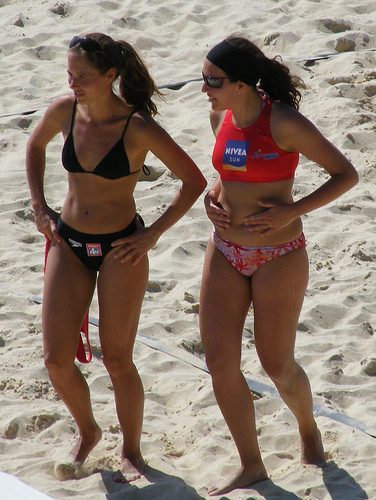

Actual Caption :
--------------------------------------------------
two woman in bathe suit walk across the sand 
two beach volleyball player walk and talk together on the sand 
two woman stand in the sand in their bikini 

Predicted Caption :
--------------------------------------------------
two girl bikini beach


Displaying 2602258549_7401a3cdae.jpg



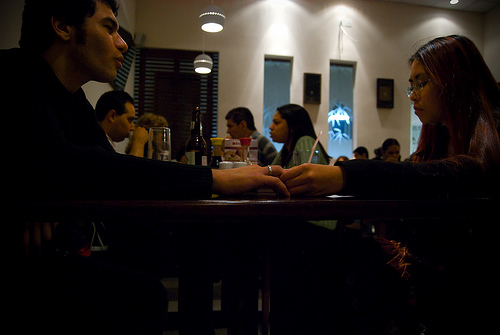

Actual Caption :
--------------------------------------------------
dim lit room with several individual include young man and woman hold hand across table 
couple hold hand across table 
man and woman be sit at restaurant table hold hand 
couple be sit in restaurant hold hand 

Predicted Caption :
--------------------------------------------------
man person at table bar dark night




In [48]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

def pred_process(y_pred):
    y_pred = y_pred.replace("startseq ", "")
    y_pred = y_pred.replace("endseq", "")
    y_pred_dedup = ""
    for x in y_pred.split():
        if x not in y_pred_dedup:
            y_pred_dedup = y_pred_dedup + " " + x
    y_pred_dedup = " ".join(y_pred_dedup.split())
    return y_pred_dedup

def generate_caption(image_id):
    # load the image
    captions = mapping[image_id]
    print('Actual Caption :')
    print("-"*50)
    for caption in captions:
        caption = caption.replace("startseq ", "")
        caption = caption.replace("endseq", "")
        print(caption)
    # predict the caption
    y_pred = predict_caption(GRUmodel, 
                             features_c[image_id], 
                             tokenizer, 
                             max_length)
    print('\nPredicted Caption :')
    print("-"*50)
    y_pred = pred_process(y_pred)
    print(y_pred)
    
for img_ in test[20:22]:
    print(f"Displaying {img_}\n")
    img_fp = os.path.join(image_dataset_fp, img_)
    im = Image.open(img_fp)
    display(im)
    generate_caption(img_)
    print()
    print()

## Take a random image from google and generate caption for that image.

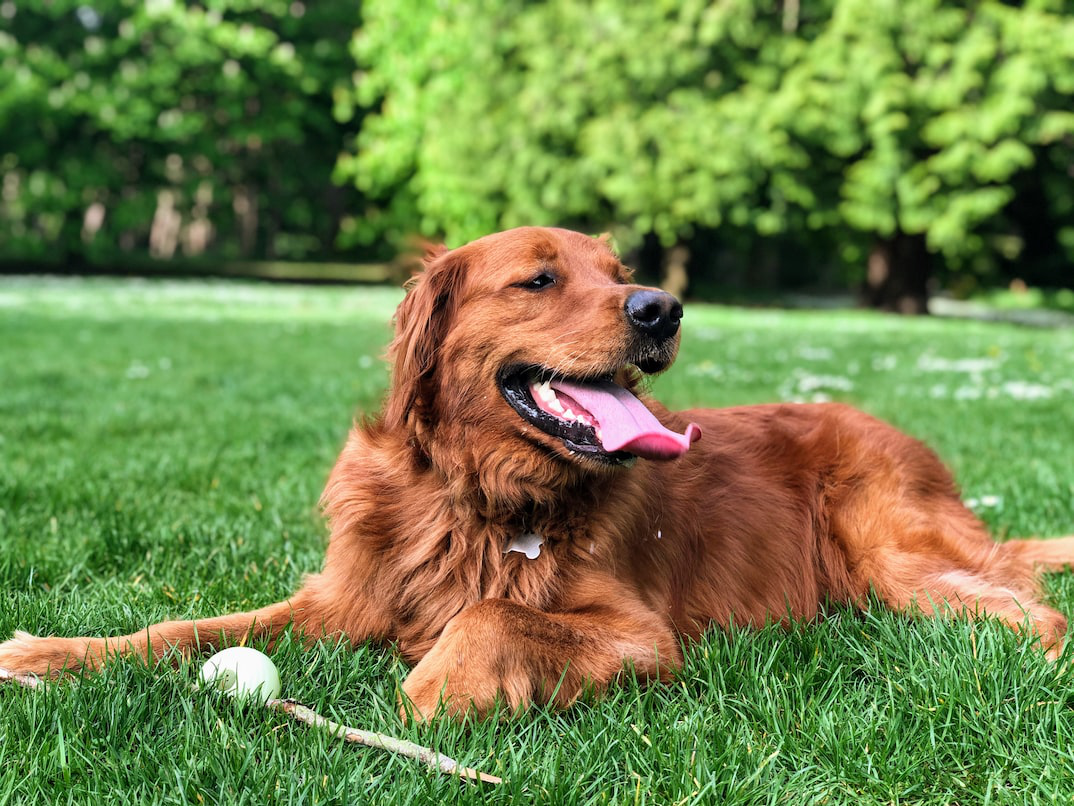


Predicted Caption:
brown dog play ball


In [49]:
import urllib.request
from PIL import Image
  
urllib.request.urlretrieve(
    'https://images.unsplash.com/photo-1589756695365-4e0915b3a246?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1074&q=80',
    "gfg.png")
  
img = Image.open("gfg.png")
display(img)
img = img.resize((256,256))

# Convert image pixels to numpy array
image = img_to_array(img)
# Reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# Preprocess image for InceptionResNetV2
image = preprocess_input(image)
# Extract Features InceptionResNetV2
img_feature = model.predict(image, verbose=0)

print()
print("Predicted Caption:")
# predict the caption
y_pred = predict_caption(GRUmodel, 
                         img_feature, 
                         tokenizer, 
                         max_length)
print(pred_process(y_pred))